# Porto Seguro’s Safe Driver Prediction

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

### Initialize

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import gc

In [2]:
import platform

print(platform.python_version())

3.6.3


In [3]:
import sys

print(sys.version)
print(sys.version_info)

3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [5]:
default_color = '#56B4E9'
colormap = plt.cm.cool

In [6]:
# Setting working directory

path = 'data/'

### Data Description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed. test.csv contains the test data. sample_submission.csv is submission file showing the correct format.
"Ind" is related to individual or driver, "reg" is related to region, "car" is related to car itself and "calc" is an calculated feature.

## Loading files

In [7]:
train = pd.read_csv(path + 'train.csv', na_values=-1)
test = pd.read_csv(path + 'test.csv', na_values=-1)

In [8]:
train.shape

(595212, 59)

In [9]:
test.shape

(892816, 58)

In [10]:
id_test = test['id'].values

## Target Analisys

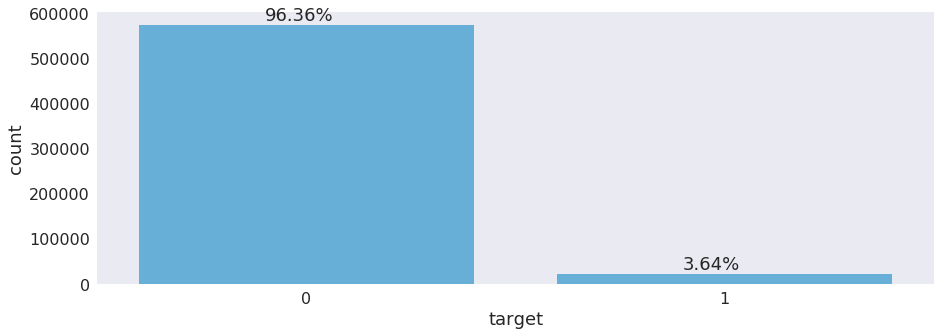

In [11]:
plt.figure(figsize=(15,5))

ax = sns.countplot('target',data=train,color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), (p.get_x()+ 0.3, p.get_height()+10000))

---

# Data analisys

In [12]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [13]:
meta_data = get_meta(train)
meta_data

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,float64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,float64
ps_ind_05_cat,input,nominal,True,float64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [14]:
meta_counts = meta_data.groupby(['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


[Text(0,0.5,'Count'),
 Text(0.5,0,'Variable Type'),
 Text(0.5,1,'Variables Count Across Datatype')]

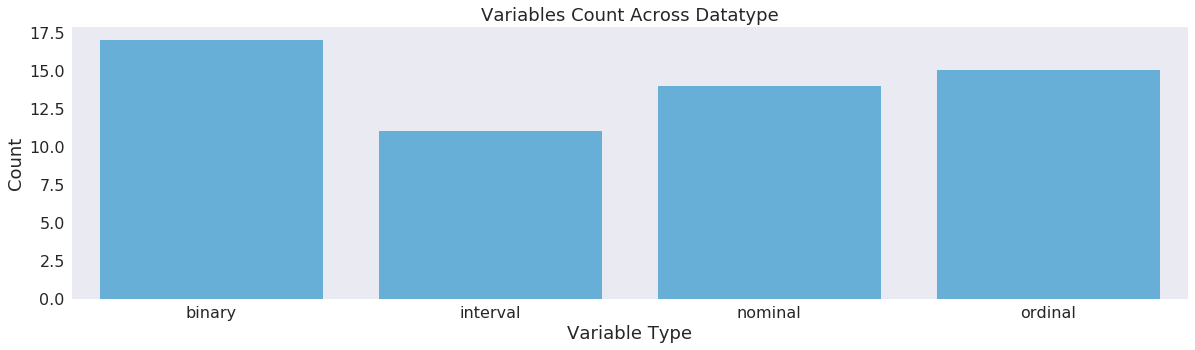

In [15]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],x="level",y="dtype",ax=ax,color=default_color)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [16]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

### Missings values

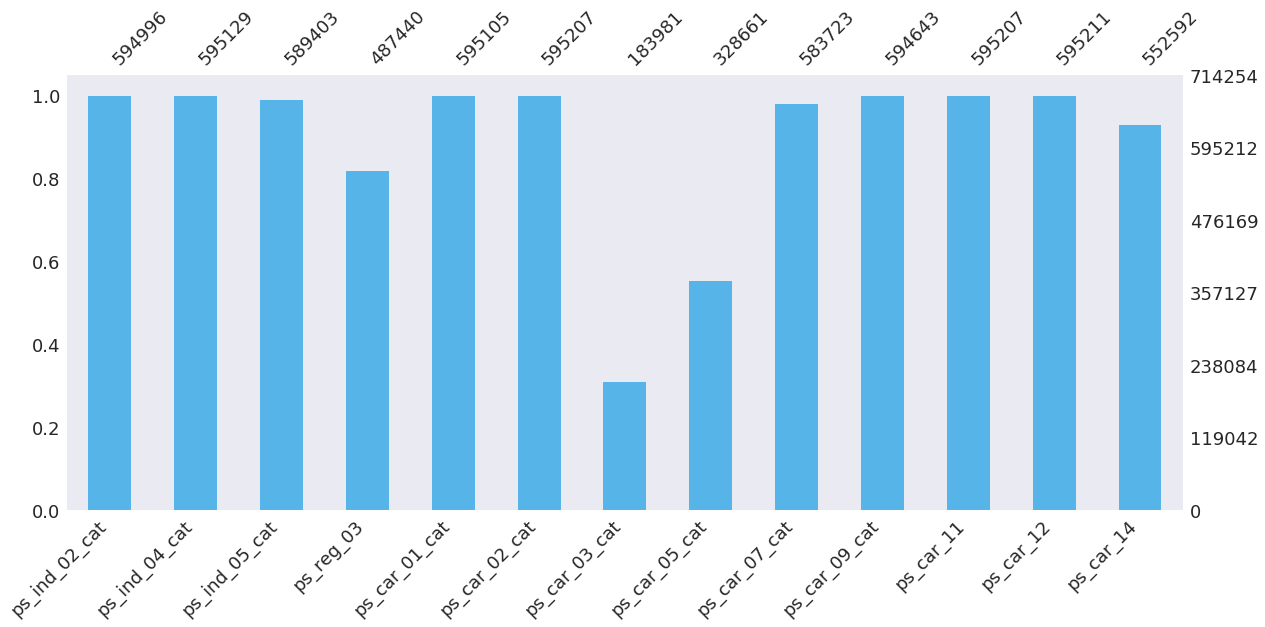

In [17]:
missingValueColumns = train.columns[train.isnull().any()].tolist()
df_null = train[missingValueColumns] 

msno.bar(df_null,figsize=(20,8),color=default_color,fontsize=18,labels=True)

### Correlations between missing values 

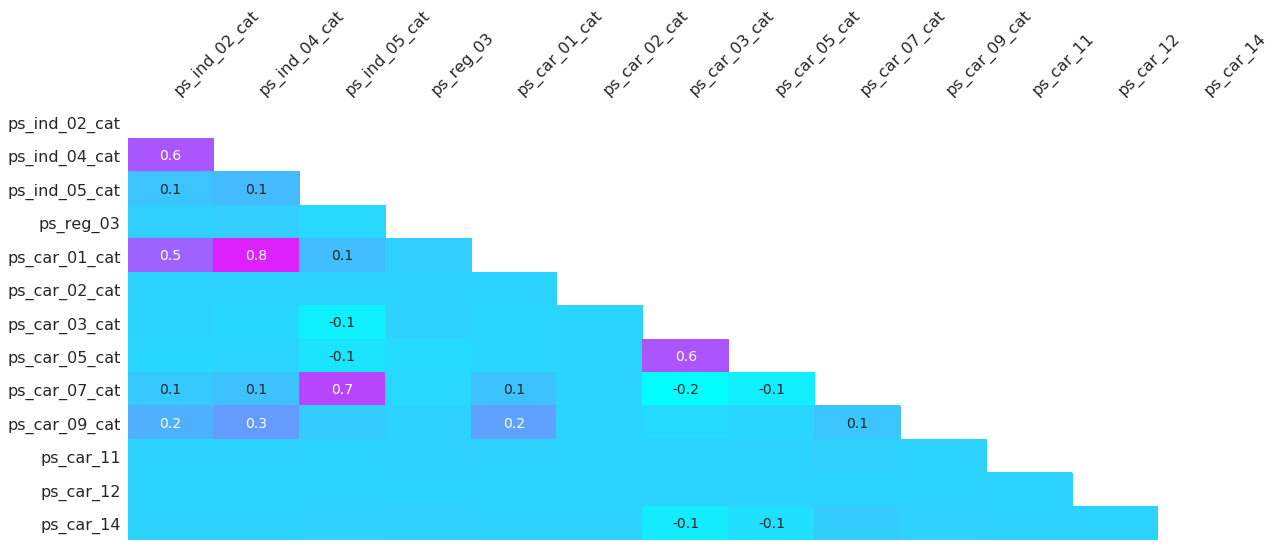

In [18]:
msno.heatmap(df_null,figsize=(20,8),cmap=colormap)

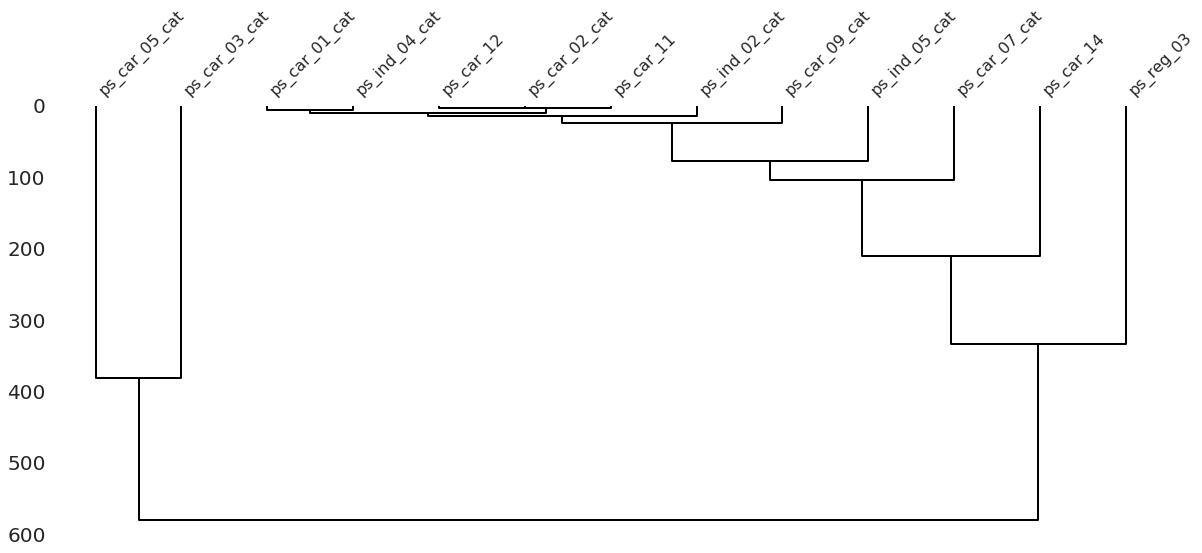

In [19]:
msno.dendrogram(df_null,figsize=(20,8))

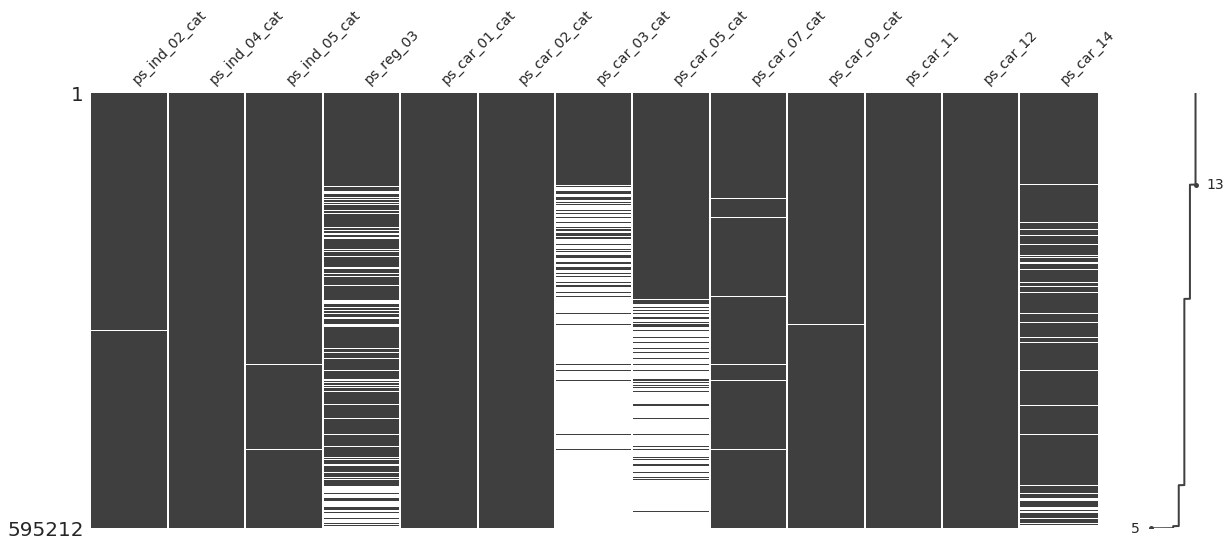

In [20]:
sorted_data = msno.nullity_sort(df_null, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

### Continuous features analysis

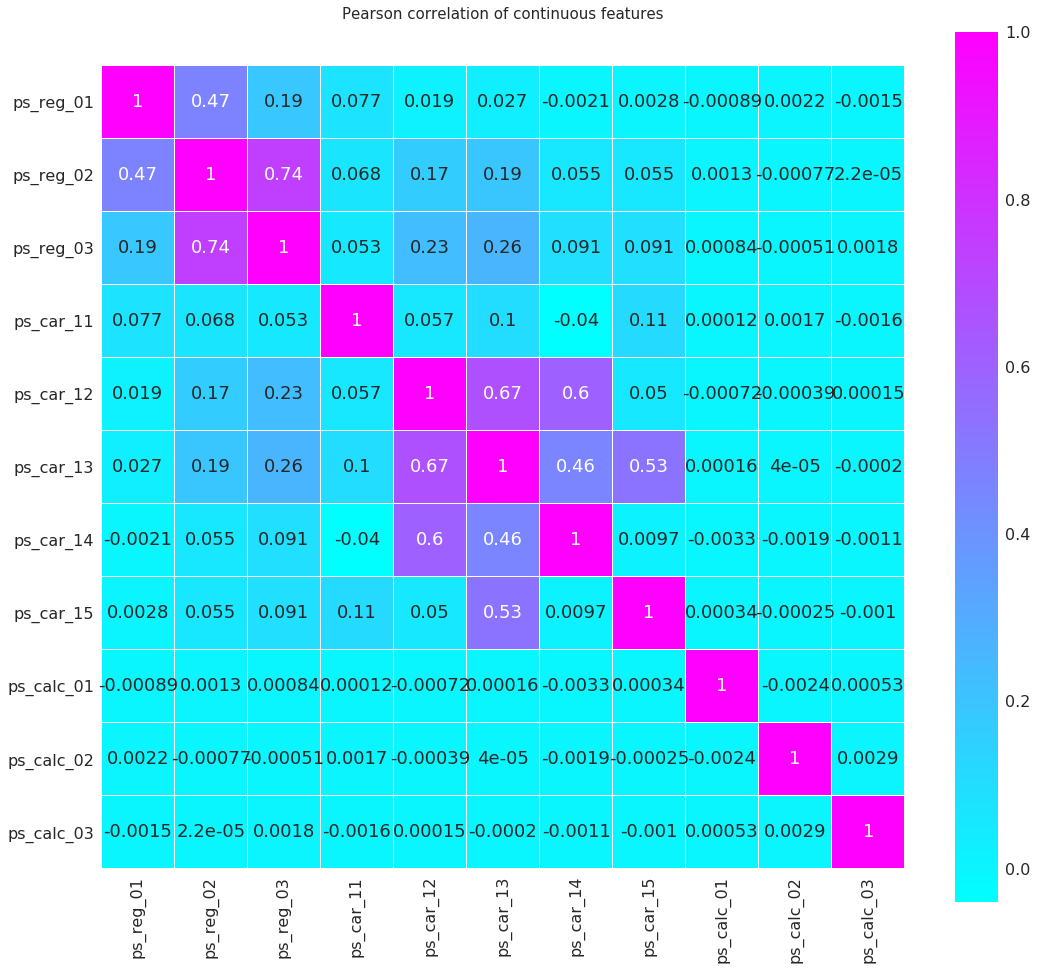

In [21]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Testing feature importantes with Random Forest

In [22]:
train.fillna(-1, inplace=True)

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['target'],axis=1), train.target)
features = train.drop(['target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [24]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [25]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

In [26]:
feature_importance

,feature,importance
0,ps_car_13,0.12
1,ps_ind_05_cat,0.08
2,ps_reg_03,0.07
3,ps_ind_17_bin,0.06
4,id,0.04
5,ps_reg_02,0.04
6,ps_ind_03,0.04
7,ps_car_07_cat,0.03
8,ps_car_12,0.03
9,ps_car_04_cat,0.03


[Text(0,0.5,'Importance'),
 Text(0.5,0,'Variable name'),
 Text(0.5,1,'Variable importances')]

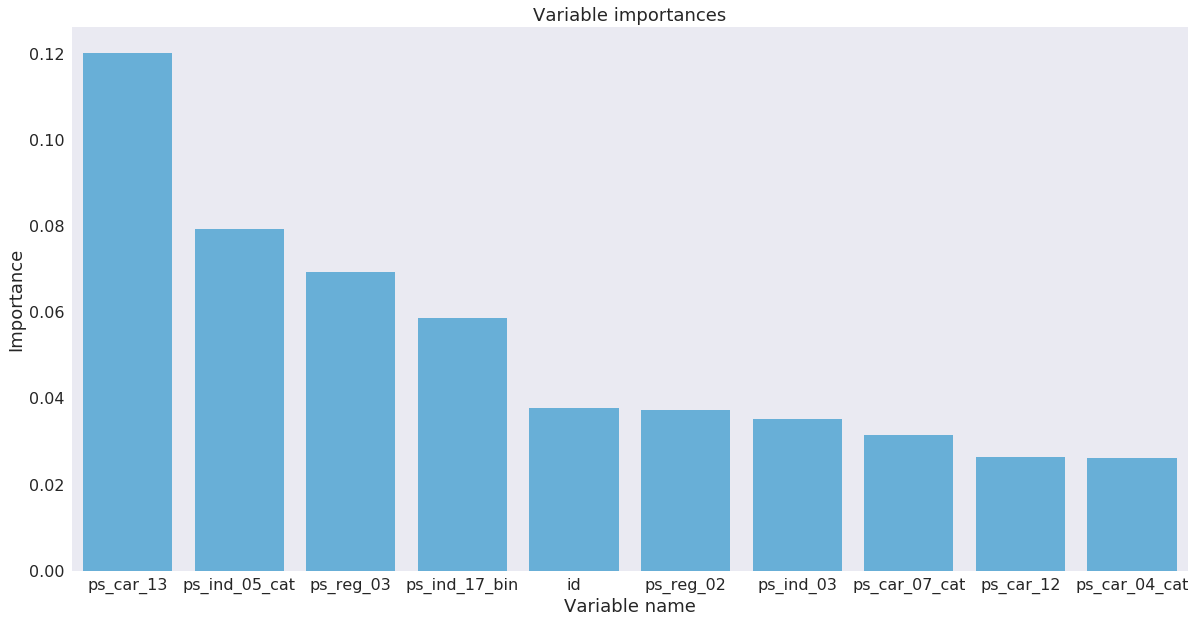

In [27]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10],x="feature",y="importance",ax=ax,color=default_color,)
ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances")

---

# Baseline models

In [34]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [29]:
#!pip install xgboost

    100% |████████████████████████████████| 1.2MB 1.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/meriat/.cache/pip/wheels/5e/c1/d6/522af54e5cc001fad4dd855117f8bf61b11d56443e06672e26
Successfully built xgboost


### Try use -1 instead of NaN

In [35]:
def cross_val_model(X,y, model, n_splits=3):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    X = np.array(X)
    y = np.array(y)


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())  

In [36]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

### Random Forest Model

In [37]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

In [38]:
rf_model = RandomForestClassifier(**rf_params)

In [39]:
X = train.drop('target',axis=1)
y = train['target']

In [40]:
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.59844
Fit RandomForestClassifier fold 2
    cross_score: 0.56801
Fit RandomForestClassifier fold 3
    cross_score: 0.52927


### XGBoost Model

In [88]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 1000
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  

#xgb_params['nthread'] = -1 # Este já é o default

In [89]:
#import sklearn
#print(sklearn.__version__)


XGB_model = XGBClassifier(**xgb_params)

In [90]:
X = train.drop('target',axis=1)
y = train['target']

In [91]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.59696
Fit XGBClassifier fold 2
    cross_score: 0.56148
Fit XGBClassifier fold 3
    cross_score: 0.53213


In [92]:
XGB_model.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [93]:
y_pred = XGB_model.predict_proba(X)[:,1]

In [106]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [95]:
roc_auc_score(y, y_pred)

0.75158619140209981

In [107]:
accuracy_score(y, (y_pred>0.5))

0.96361800501333983

In [108]:
f1_score(y, (y_pred>0.5))

0.0035890121014125987

In [96]:
results_xgb = pd.concat([pd.Series(y), pd.Series(y_pred)], axis=1)

In [97]:
results_xgb.columns = ['target', 'pred']

In [98]:
results_xgb.head()

,target,pred
0,0,0.08
1,0,0.06
2,0,0.03
3,0,0.04
4,0,0.05


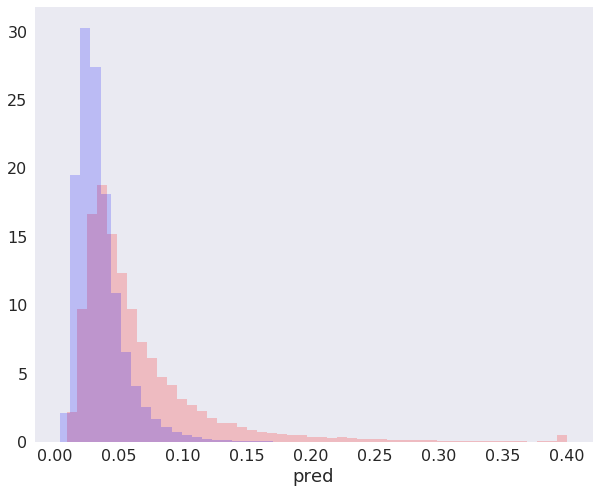

In [102]:
plt.figure(figsize=(10,8))
sns.distplot(results_xgb[results_xgb.target==1].pred.clip(0,0.4), norm_hist=True, kde=False, color='r', hist_kws={'alpha':0.2})
sns.distplot(results_xgb[results_xgb.target==0].pred.clip(0,0.4), norm_hist=True, kde=False, color='b', hist_kws={'alpha':0.2})

In [119]:
train_pred = train.copy()
train_pred.drop('target', axis=1, inplace=True)
train_pred['pred'] = XGB_model.predict_proba(train_pred)[:,1]

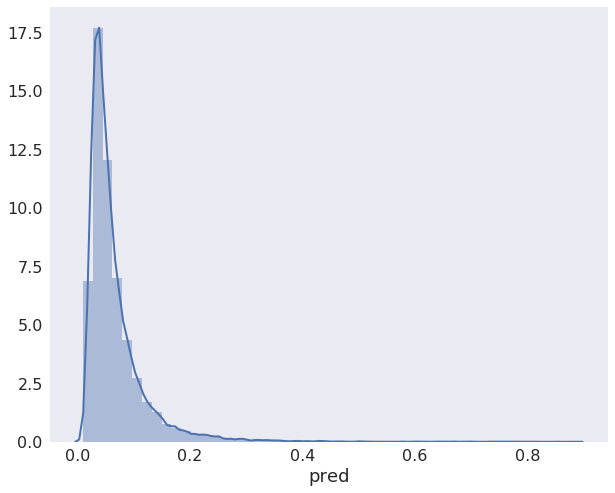

In [122]:
plt.figure(figsize=(10,8))
sns.distplot(train_pred[train.target==1].pred)

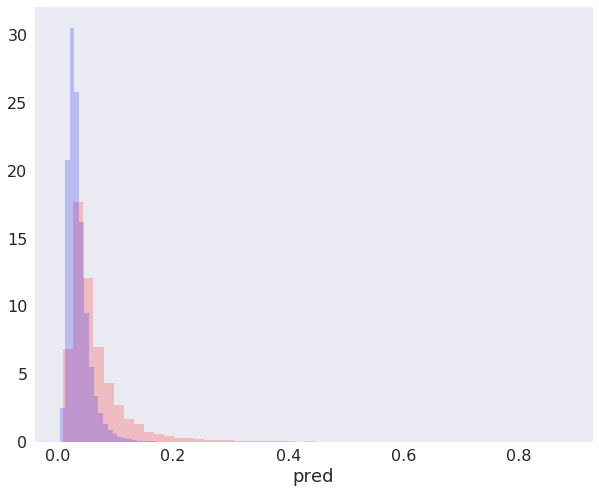

In [123]:
plt.figure(figsize=(10,8))
sns.distplot(train_pred[train.target==1].pred, norm_hist=True, kde=False, color='r', hist_kws={'alpha':0.2})
sns.distplot(train_pred[train.target==0].pred, norm_hist=True, kde=False, color='b', hist_kws={'alpha':0.2})

In [124]:
train_pred.columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'pred'],
  

In [127]:
colunas = X.columns
test = test[colunas]

In [129]:
sub = pd.DataFrame(columns=['id','target'])
sub['target'] = XGB_model.predict_proba(test)[:,1]
sub['id'] = id_test
sub.to_csv('v0_main.csv', index=False)

In [130]:
pd.read_csv('v0_main.csv')

,id,target
0,0,0.05
1,1,0.04
2,2,0.04
3,3,0.03
4,4,0.10
5,5,0.08
6,6,0.02
7,8,0.08
8,10,0.07
9,11,0.08


# Feature Engineering

## One-hot Encoding effect

Varibales to try ohe

In [131]:
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

In [132]:
def OHE_by_unique(train, one_hot, limit):
    
    #ONE-HOT enconde features with more than 2 and less than 'limit' unique values
    df = train.copy()
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

In [133]:
train_ohe = OHE_by_unique(train, one_hot, 7)

In [134]:
train.shape

(595212, 59)

In [135]:
train_ohe.shape

(595212, 104)

In [136]:
X_ohe = train_ohe.drop('target',axis=1)
y_ohe = train_ohe['target']

In [137]:
cross_val_model(X_ohe, y_ohe, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.59971
Fit RandomForestClassifier fold 2
    cross_score: 0.57920
Fit RandomForestClassifier fold 3
    cross_score: 0.51499


In [138]:
cross_val_model(X_ohe, y_ohe, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.59279
Fit XGBClassifier fold 2
    cross_score: 0.56025
Fit XGBClassifier fold 3
    cross_score: 0.53265


In [139]:
del train_ohe; gc.collect()

4712

## Extra features effect

### Extra Features

In [140]:
train_ext = train.copy()

In [141]:
train_ext['null_sum'] = train_ext[train_ext==-1].count(axis=1)

In [142]:
train_ext['bin_sum']  = train_ext[col_binary].sum(axis=1)

In [143]:
train_ext['ord_sum']  = train_ext[col_ordinal].sum(axis=1)

In [144]:
train_ext['internval_median']  = train_ext[col_internval].sum(axis=1)

In [145]:
X_ext = train_ext.drop('target',axis=1)
y_ext = train_ext['target']

In [146]:
cross_val_model(X_ext, y_ext, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.59751
Fit RandomForestClassifier fold 2
    cross_score: 0.57115
Fit RandomForestClassifier fold 3
    cross_score: 0.55084


In [147]:
cross_val_model(X_ext, y_ext, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.60009
Fit XGBClassifier fold 2
    cross_score: 0.56282
Fit XGBClassifier fold 3
    cross_score: 0.52965


In [148]:
del train_ext; gc.collect;

In [ ]:
sub = pd.DataFrame(columns=['id','target'])
sub['target'] = XGB_model.predict_proba(test)[:,1]
sub['id'] = id_test
sub.to_csv('v0_main.csv', index=False)

---

# Parameter optimization

In [149]:
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [150]:
import random
import itertools
N_HYPEROPT_PROBES = 10
EARLY_STOPPING = 80
HOLDOUT_SEED = 123456
HOLDOUT_SIZE = 0.10
HYPEROPT_ALGO = tpe.suggest  #  tpe.suggest OR hyperopt.rand.suggest
DATASET = 'clean' # 'raw' | 'clean' | 'extended'
SEED0 = random.randint(1,1000000000)
NB_CV_FOLDS = 5

In [151]:
obj_call_count = 0
cur_best_score = 0

### Random Forest

In [152]:
space ={
    'n_estimators'           : hp.choice('n_estimators',         np.arange(30, 500,  dtype=int)),       
    'max_depth'              : hp.choice("max_depth",            np.arange(4, 20,    dtype=int)),
    'min_samples_split'      : hp.choice("min_samples_split",    np.arange(2, 30,    dtype=int)),
    'min_samples_leaf'      : hp.choice("min_samples_leaf",    np.arange(1, 10,    dtype=int)),
    'criterion'              : hp.choice('criterion', ["gini", "entropy"]),
    'class_weight'           : hp.choice('class_weight', ['balanced_subsample', None]),
    'n_jobs'                : -1,
    'oob_score'              : True     
   }

In [153]:
def objective_RF(space):
    
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    
    global obj_call_count, cur_best_score, X_train, y_train, test, X_val, y_val

    
    obj_call_count += 1
    print('\nLightGBM objective call #{} cur_best_score={:7.5f}'.format(obj_call_count,cur_best_score) )

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    print('Params:', str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params if not k.startswith('column:')]))


    params = sample(space)
        
    mdl = RandomForestClassifier(**params)
    
    cv_score = cross_val_score(mdl, X_train, y_train).mean()

    print( 'CV finished ; \n cv_score={:7.5f}'.format(cv_score ) )
    
    _model = mdl.fit(X_train, y_train)
    
    predictions = _model.predict_proba(X)[:,1](X_val)
    
    score = roc_auc_score(y_val, predictions)
    print('valid score={}'.format(score))
    
    
    do_submit = score > 0.64

    if score > cur_best_score:
        cur_best_score = score
        print('NEW BEST SCORE={}'.format(cur_best_score))
        do_submit = True

    if do_submit:
        submit_guid = uuid4()

        print('Compute submissions guid={}'.format(submit_guid))

        y_submission = gbm_model.predict(test, num_iteration=n_rounds)
        submission_filename = 'rf_score={:13.11f}_submission_guid={}.csv'.format(score,submit_guid)
        pd.DataFrame(
        {'id':test_id, 'target':y_submission}
        ).to_csv(submission_filename, index=False)
       
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [162]:
space_XGB ={
    'max_depth'        : hp.choice("max_depth",        np.arange(4, 7,    dtype=int)), 
    'learning_rate'    : hp.loguniform('learning_rate', -6.9, -2.3),
    'n_estimators'     : hp.loguniform('n_estimators', 100, 1000),
    'objective'        : 'binary:logistic',
    'booster'         : 'gbtree',       
    'reg_alpha'       : hp.uniform('reg_alpha', 1e-6, 1e-4 ),
    'reg_lambda'      : hp.uniform('reg_lambda', 1e-6, 1e-4 ), 
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.6, 0.8),
    'min_child_weight ': hp.uniform('min_child_weight', 0.6, 0.8),   
    'random_state'    : hp.randint('random_state',2000000)
   }

In [ ]:
trials = Trials()
best = fmin(fn=objective_RF,
                     space=space_RF,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)

print('-'*50)
print('The best params for RF:')
print( best )
print('\n\n')

In [ ]:
def objective_XGB(space):
    from sklearn.model_selection import cross_val_score
    from xgboost import XGBClassifier
   
    global obj_call_count, cur_best_score, X_train, y_train, test, X_val, y_val

    
    obj_call_count += 1
    print('\nLightGBM objective call #{} cur_best_score={:7.5f}'.format(obj_call_count,cur_best_score) )

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    print('Params:', str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params if not k.startswith('column:')]))


    params = sample(space)
        
    mdl = XGBClassifier(**params)
    
    cv_score = cross_val_score(mdl, X_train, y_train).mean()

    print('CV finished ; \n cv_score={:7.5f}'.format(cv_score ) )
    
    _model = mdl.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc',early_stopping_rounds =30, verbose=True)
    
    params.update({'n_estimators': _model.best_iteration})
    
    predictions = _model.predict_proba(X)[:,1](X_val)
    
    score = roc_auc_score(y_val, predictions)
    print('valid score={}'.format(score))
    
    
    do_submit = score > 0.64

    if score > cur_best_score:
        cur_best_score = score
        print('NEW BEST SCORE={}'.format(cur_best_score))
        do_submit = True

    if do_submit:
        submit_guid = uuid4()

        print('Compute submissions guid={}'.format(submit_guid))

        y_submission = gbm_model.predict(test, num_iteration=n_rounds)
        submission_filename = 'xgb_score={:13.11f}_submission_guid={}.csv'.format(score,submit_guid)
        pd.DataFrame(
        {'id':test_id, 'target':y_submission}
        ).to_csv(submission_filename, index=False)
       
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

In [ ]:
trials = Trials()
best = fmin(fn=objective_XGB,
                     space=space_XGB,
                     algo=HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)

print('-'*50)
print('The best params for XGB:')
print( best )
print('\n\n')

# Stacking Models

In [164]:
train_stack = train.copy()

In [165]:
test_stack  = test.copy()

In [166]:
one_hot = {c: list(train[c].unique()) for c in train.columns if c not in ['id','target']}

In [167]:
train_stack = train_stack.replace(-1, np.NaN)

d_median    = train_stack.median(axis=0)
d_mean      = train_stack.mean(axis=0)

train_stack = train_stack.fillna(-1)

In [168]:
def transform(df, ohe, d_median, d_mean):
    
   
    dcol = [c for c in df.columns if c not in ['id','target']]
    
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    df['negative_one_vals'] = np.sum((df[dcol]==-1).values, axis=1)
    
    for c in dcol:
        if '_bin' not in c:
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')]   = (df[c].values > d_mean[c]).astype(np.int)

    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < 7:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
    return df

In [169]:
train_stack = transform(train_stack, one_hot,d_median, d_mean)
test_stack = transform(test_stack, one_hot, d_median, d_mean)

In [170]:
train_stack['null_sum'] = train_stack[train_stack==-1].count(axis=1)
train_stack['bin_sum']  = train_stack[col_binary].sum(axis=1)
train_stack['ord_sum']  = train_stack[col_ordinal].sum(axis=1)
train_stack['internval_median']  = train_stack[col_internval].sum(axis=1)

In [171]:
test_stack['null_sum'] = test_stack[train_stack==-1].count(axis=1)
test_stack['bin_sum']  = test_stack[col_binary].sum(axis=1)
test_stack['ord_sum']  = test_stack[col_ordinal].sum(axis=1)
test_stack['internval_median']  = test_stack[col_internval].sum(axis=1)

In [172]:
col = [c for c in train_stack.columns if c not in ['id','target']]
col = [c for c in col if not c.startswith('ps_calc_')] ## Droping ps_cal_ vars

In [173]:
dups = train_stack[train_stack.duplicated(subset=col, keep=False)]

In [174]:
train_stack = train_stack[~(train_stack.index.isin(dups.index))]

In [175]:
target_stack = train_stack['target']

In [176]:
train_stack = train_stack[col]

In [177]:
target_stack.shape

(595212,)

In [178]:
test_stack = test_stack[col]

In [179]:
test_stack.shape

(892816, 134)

### Testing combined transformations without stacking

In [180]:
X_stack = train_stack
y_stack = target_stack

In [181]:
cross_val_model(X_stack, y_stack, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.62330
Fit RandomForestClassifier fold 2
    cross_score: 0.62609
Fit RandomForestClassifier fold 3
    cross_score: 0.62351


In [182]:
cross_val_model(X_stack, y_stack, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.62155
Fit XGBClassifier fold 2
    cross_score: 0.62655
Fit XGBClassifier fold 3
    cross_score: 0.62065


## Ensemble CV

In [183]:
class Ensemble(object):

    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        from sklearn.model_selection import StratifiedKFold
        from sklearn.model_selection import cross_val_score
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2017).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [184]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

In [185]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.012983377237040745
xgb_params['n_estimators'] = 750
xgb_params['max_depth'] = 6
xgb_params['reg_alpha'] = 6.037927795611329e-05
xgb_params['reg_lambda'] = 7.3327894939712616e-06
xgb_params['colsample_bytree'] = 0.6013536865241922 
xgb_params['min_child_weight'] = 0.6020963925048413

In [186]:
rf_model = RandomForestClassifier(**rf_params)

In [187]:
xgb_model = XGBClassifier(**xgb_params)

In [188]:
log_model = LogisticRegression()

In [189]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (rf_model, xgb_model))    

In [190]:
y_pred = stack.fit_predict(train_stack, target_stack, test_stack)     

Fit RandomForestClassifier fold 1
Fit RandomForestClassifier fold 2
Fit RandomForestClassifier fold 3
Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Stacker score: 0.63860


## Make submission

In [191]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('v1_main.csv', index=False)